<a href="https://colab.research.google.com/github/CorentinMAG/NLP/blob/main/us_airline_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To infer the tweet's sentiments we will use two classifiers:
* logistic regression
* multinomial naive bayes

# Set up

In [ ]:
!pip install emoji
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We download the Twitter US Airline sentiment dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset = os.path.join(os.getcwd(),'gdrive/My Drive/datasets/TweetsUSAirline.csv')
df = pd.read_csv(dataset)

# we shuffle data in case the dataset is sorted
df = df.reindex(np.random.permutation(df.index))

# we only keep the columns airline_sentiment, text
df = df[['airline_sentiment','text']]

we have 3 sentiments:
* neutral
* negative
* positive

# data visualization

Let's look at the tweets !

In [ ]:
print(df)

      airline_sentiment                                                                                                                                        text
10620  negative          @USAirways told to work it out ourselves #joke #fail                                                                                      
13609  negative          @AmericanAir that all AA is for USAir Elite members. It's one big disappointment in the way we are treated. #epicfailure                  
2955   negative          @united Bummer. Might have to go with @AmericanAir card instead. TY for response though.                                                  
3585   negative          @united well the income flight to dca to take us to ewr was delayed and it made us miss our connection to FLL so yes hotels were necessary
2087   negative          @united we have tried to change our flight THREE times on the phone and got disconnected each time.                                       
...         ... 

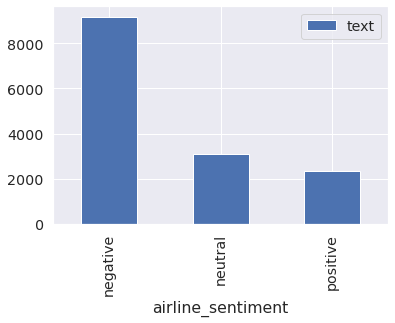

In [ ]:
df.groupby('airline_sentiment').count().plot.bar()

We have an imbalanced distribution of the target class labels  
We will create a class that can retrieve some stats from our dataset:
* count number of word in a tweet
* count mentions in a tweet
* count html tag in a tweet
* count hashtags in a tweet
* count uppercase word in a tweet
* count questions/exclamations in a tweet
* count url in a tweet

In [ ]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           ,'count_emoji':count_emojis
                          })
        
        return df

In [ ]:
tc = TextCounts()

# we create our stats dataframe
df_stats = tc.fit_transform(df['text'])

# we add the sentiment column
df_stats['airline_sentiment'] = df['airline_sentiment']

We will plot our stats

In [ ]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0  8.0   14.0  21.0  33.0


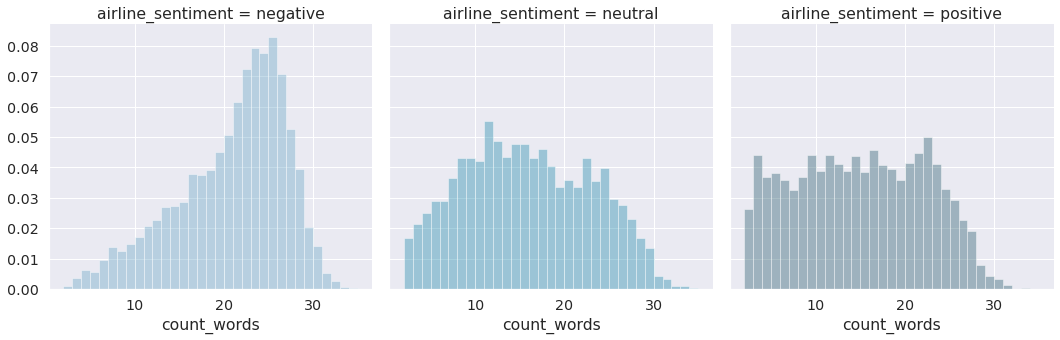

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


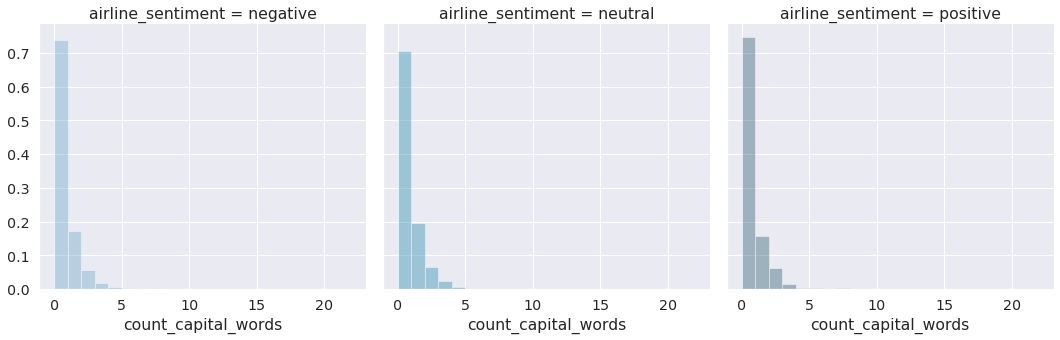

Descriptive stats for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral            3099.0  0.169732  0.401225  0.0  0.0  0.0  0.0  3.0
positive           2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


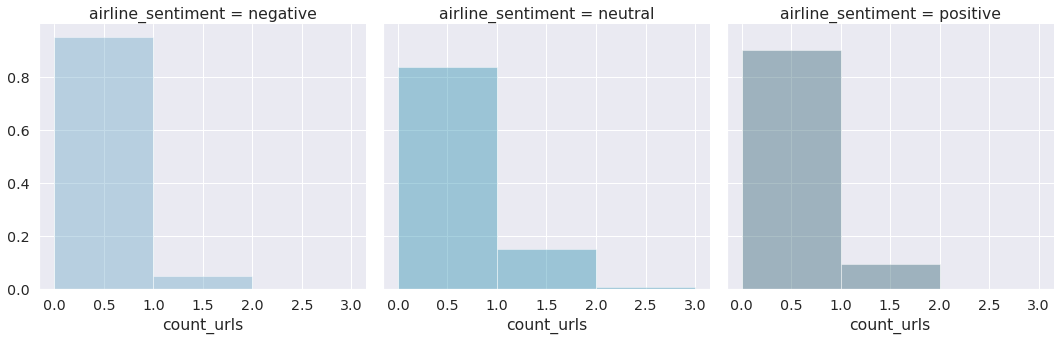

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


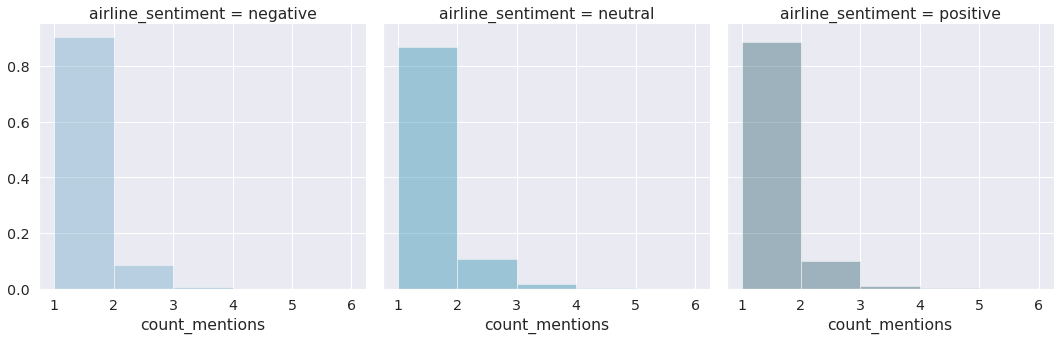

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.634125  1.143958  0.0  0.0  0.0  1.0  27.0
neutral            3099.0  0.665053  0.928761  0.0  0.0  0.0  1.0  12.0
positive           2363.0  0.892510  1.199191  0.0  0.0  1.0  1.0  13.0


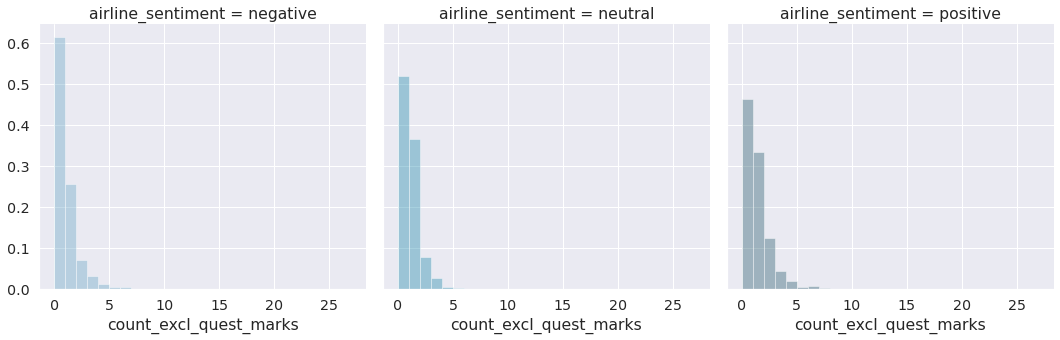

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


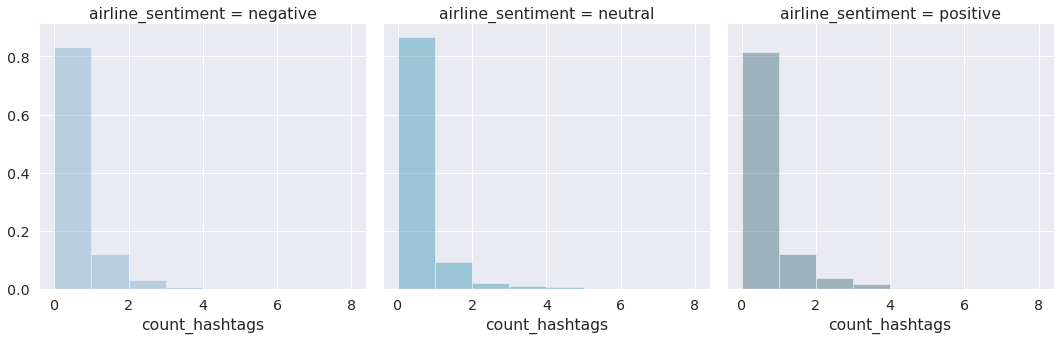

Descriptive stats for count_emoji
---------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.028547  0.258772  0.0  0.0  0.0  0.0  8.0 
neutral            3099.0  0.076154  0.494654  0.0  0.0  0.0  0.0  13.0
positive           2363.0  0.181549  1.257512  0.0  0.0  0.0  0.0  40.0


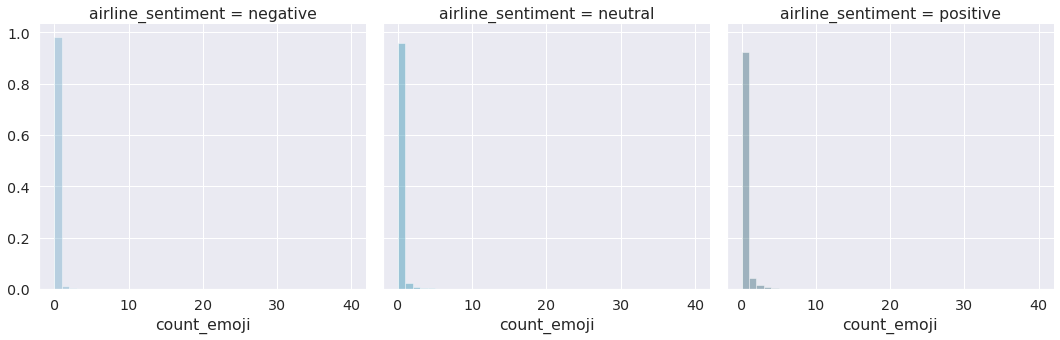

In [ ]:
show_dist(df_stats,'count_words')
show_dist(df_stats,'count_capital_words')
show_dist(df_stats,'count_urls')
show_dist(df_stats,'count_mentions')
show_dist(df_stats,'count_excl_quest_marks')
show_dist(df_stats,'count_hashtags')
show_dist(df_stats,'count_emoji')

* The number of words used in the tweets is rater low. Maximum number of words is 36 and there are even tweets with only 2 words. So we'll have to be careful during data cleaning not to remove too many words. On the other hand, the text processing will be faster. Negative tweets contain more words than neutral or positive tweets.
* All tweets have at least one mention. Probably this is the result of extracting the tweets based on mentions in the Twitter data. There seems to be no difference in number of mentions with regard to the sentiment.
* Most of the tweets do not contain hash tags. So probably this variable will not be retained during model training. Again, no difference in number of hash tags with regard to the sentiment.
* Most of the tweets do not contain capitalized words and we do not see a difference in distribution between the sentiments.
* The positive tweets seem to be using a bit more exclamation or question marks.
* Most tweets do not contain a URL.

# Text cleaning

Before we start using the tweets' text we clean it. We'll do this in the class CleanText:

* remove the mentions, as we want to make the model generalisable to tweets of other airline companies too.
* remove the hash tag sign (#) but not the actual tag as this may contain information
* set all words to lowercase
* remove all punctuations, including the question and exclamation marks
* remove the urls as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes
* remove digits
* remove stopwords
* apply the PorterStemmer to keep the stem of the words

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):

    # we remove @....
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    # we remove urls in the tweet
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    # we remove punctuation marks
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        # maketrans(str1,str2) -> each character in the first string  is a replacement to its corresponding index in the second string
        # Every punctuation symbol will be replaced by a space
        trantab = str.maketrans(punct, len(punct)*' ')  
        return input_text.translate(trantab)

    # we remove all digits because they are useless
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    # we convert all text in lowercase 
    def to_lower(self, input_text):
        return input_text.lower()
    
    # we remove the most frequents words
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def remove_emojis(self,input_text):
      demojize_input = emoji.demojize(input_text)
      # emojis has been demojize so they are in this format :***:
      return re.sub(r':[a-z_&]+:','',demojize_input)

    
    # we perform stemming (base representation of words)
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.remove_punctuation).apply(self.remove_emojis).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [ ]:
ct = CleanText()

dff = df.copy()

cleaned_data = ct.fit_transform(dff['text'])
cleaned_data.sample(5)

12222    glad rt bet bird wish flown south winter                         
3936     point upc code check baggag tell luggag vacat day tri swimsuit   
367      vx jfk la dirti plane not standard                               
12257    tell mean work need estim time arriv pleas need laptop work thank
2957     sure busi go els airlin travel name kathryn sotelo               
Name: text, dtype: object

we will show the most frequent words

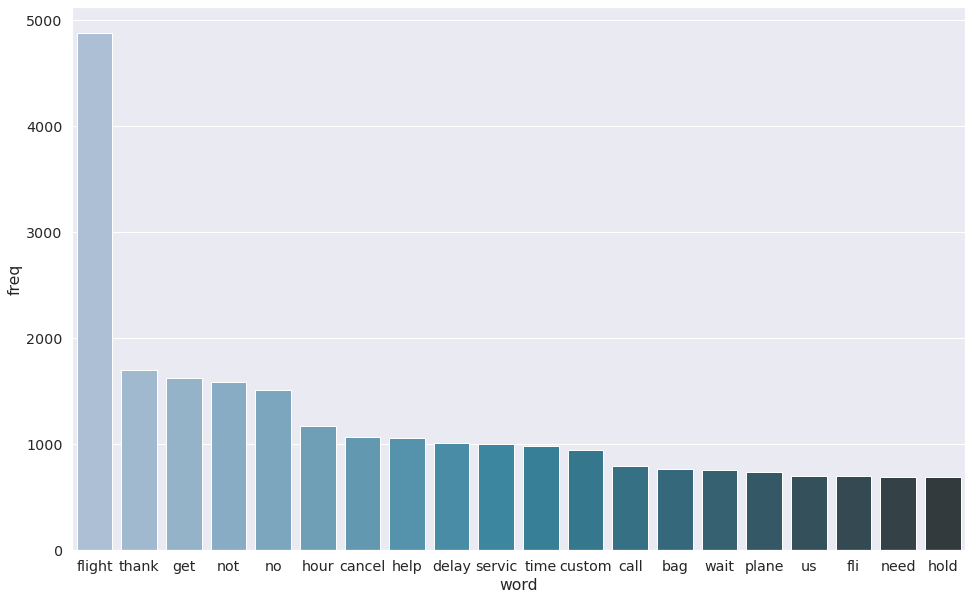

In [ ]:
cv = CountVectorizer()
bow = cv.fit_transform(cleaned_data)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [ ]:
cleaned_data.value_counts()

thank                                                                               146
fleet fleek                                                                         24 
                                                                                    22 
sent                                                                                14 
thank much                                                                          14 
                                                                                    .. 
complet let tonight gate agent ambival much sad amp                                 1  
hi bked cool birthday trip add elev no caus enter middl name flight book problem    1  
cannot even open laptop seat paid premium let                                       1  
dear virgin custom strand sf day amp cost least accommod                            1  
not agent voic activ system not work right no email cancel flightlat lot problem    1  
Name: text, Length: 14018, dtype

We see that now we have 22 empty tweets !! 
That could lead to some issues, so we have to handle that !
* we can remove empty row from the dataframe
* we can impute the missing value with some placeholder like [no_text]

For this time, we will use a placeholder

In [ ]:
# we append this processed data to the dff dataframe
dff['cleaned_text'] = cleaned_data
dff.head()

,airline_sentiment,text,cleaned_text
10620,negative,@USAirways told to work it out ourselves #joke #fail,told work joke fail
13609,negative,@AmericanAir that all AA is for USAir Elite members. It's one big disappointment in the way we are treated. #epicfailure,aa usair elit member one big disappoint way treat epicfailur
2955,negative,@united Bummer. Might have to go with @AmericanAir card instead. TY for response though.,bummer might go card instead ty respons though
3585,negative,@united well the income flight to dca to take us to ewr was delayed and it made us miss our connection to FLL so yes hotels were necessary,well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087,negative,@united we have tried to change our flight THREE times on the phone and got disconnected each time.,tri chang flight three time phone got disconnect time


In [ ]:
# we replace empty tweet with a placeholder
empty_tweet = dff['cleaned_text'] == ''
dff[empty_tweet]='[no_text]'
dff.cleaned_text.value_counts()

thank                                                                                                              146
fleet fleek                                                                                                        24 
[no_text]                                                                                                          22 
thank much                                                                                                         14 
rt fleet fleek                                                                                                     14 
                                                                                                                   .. 
custom servic dead last wk flt delay cancel flight bag lost day last nt flt delay cancel flight no meal voucher    1  
complet let tonight gate agent ambival much sad amp                                                                1  
hi bked cool birthday trip add elev no caus ente

# train/test dataset

we will split our initial dataset in two datasets by using the ```train_test_split()``` function from sklearn  
We will use 90% of our data for the training part

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(dff.drop(['airline_sentiment','text'], axis=1), dff.drop(['text','cleaned_text'],axis=1), test_size=0.1, random_state=37)
X_train = X_train['cleaned_text'].tolist()
Y_train = Y_train['airline_sentiment'].tolist()


X_test = X_test['cleaned_text'].tolist()
Y_test = Y_test['airline_sentiment'].tolist()


# hyperparameters tuning 

we will try two vectorizers :
* TD-IDF vectorizer
* CountVectorizer

and we will train a logistic regression and a multinomial naïves bayes.  
In order to get the best result, we will use a **cross validation** and ```GridSearchCV()``` function to tune the hyperparameters

The GridSearchCV will generate a report on the test data. This provide some interresting metrics. These metrics are the precision, recal and f1 score.

We will also plot the confusion matrix.

In [ ]:
def grid_search(vect,clf,vect_parameters,clf_parameters):

  pipeline = Pipeline([('vect',vect),('clf',clf)])
  parameters = dict()
  parameters.update(vect_parameters)
  parameters.update(clf_parameters)

  grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)

  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  pprint(parameters)

  t0 = time()
  
  grid_search.fit(X_train, Y_train)
  print("done in %0.3fs" % (time() - t0))

  print("Best CV score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
  print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, Y_test))
  print("\n")
  print("Classification Report Test Data")
  print(classification_report(Y_test, grid_search.best_estimator_.predict(X_test)))

  print("Confusion matrix")
  confusion_m = confusion_matrix(Y_test, grid_search.best_estimator_.predict(X_test))
  print(confusion_m)
  print()
  plot_confusion_matrix(grid_search.best_estimator_, X_test, Y_test, normalize='true', cmap=plt.cm.Blues, values_format=".2f")
                        
  return 

# Parameters for gridSearchCV

In [ ]:
#parameters for vectorizers
tdidf = TfidfVectorizer()
ctv = CountVectorizer()
vect_parameters = {
    'vect__min_df':(1,2),
    'vect__max_df':(0.25,0.5,0.75),
    'vect__ngram_range':((1,1),(1,2))
    
}

# parameters for multinomial naïves bayes classifiers
mnb = MultinomialNB()
mnb_parameters = {
    'clf__alpha': (0.25, 0.5, 0.75)  
}

# parameters for logistic regression
logreg = LogisticRegression()
logreg_parameters = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__max_iter':(100,500,1000)
}

# CountVectorizer

We will try this vectorizer with both classifiers

## Multinomial naïves Bayes

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'vect__max_df': (0.25, 0.5, 0.75),
 'vect__min_df': (1, 2),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   56.7s finished


done in 57.208s
Best CV score: 0.771
Best parameters set:
	clf__alpha: 0.75
	vect__max_df: 0.5
	vect__min_df: 2
	vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.776


Classification Report Test Data
              precision    recall  f1-score   support

   [no_text]       0.00      0.00      0.00         1
    negative       0.80      0.92      0.86       910
     neutral       0.68      0.43      0.52       320
    positive       0.76      0.68      0.72       233

    accuracy                           0.78      1464
   macro avg       0.56      0.51      0.52      1464
weighted avg       0.77      0.78      0.76      1464

Confusion matrix
[[  0   0   1   0]
 [  0 840  50  20]
 [  0 152 137  31]
 [  0  60  14 159]]



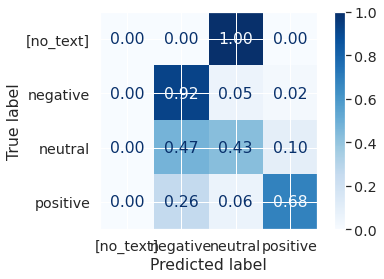

In [ ]:
grid_search(ctv,mnb,vect_parameters,mnb_parameters)

## LogisticRegression

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__max_iter': (100, 500, 1000),
 'vect__max_df': (0.25, 0.5, 0.75),
 'vect__min_df': (1, 2),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 15.1min finished


done in 911.462s
Best CV score: 0.794
Best parameters set:
	clf__C: 0.5
	clf__max_iter: 100
	vect__max_df: 0.5
	vect__min_df: 1
	vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.811


Classification Report Test Data
              precision    recall  f1-score   support

   [no_text]       1.00      1.00      1.00         1
    negative       0.84      0.92      0.88       910
     neutral       0.72      0.56      0.63       320
    positive       0.80      0.75      0.77       233

    accuracy                           0.81      1464
   macro avg       0.84      0.81      0.82      1464
weighted avg       0.81      0.81      0.81      1464

Confusion matrix
[[  1   0   0   0]
 [  0 834  56  20]
 [  0 117 179  24]
 [  0  44  15 174]]



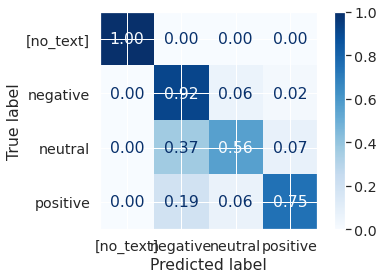

In [ ]:
grid_search(ctv,logreg,vect_parameters,logreg_parameters)

# TDIDFVectorizer

## Multinomial naïves Bayes

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'vect__max_df': (0.25, 0.5, 0.75),
 'vect__min_df': (1, 2),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   58.0s finished


done in 58.509s
Best CV score: 0.754
Best parameters set:
	clf__alpha: 0.25
	vect__max_df: 0.5
	vect__min_df: 2
	vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.753


Classification Report Test Data
              precision    recall  f1-score   support

   [no_text]       1.00      1.00      1.00         1
    negative       0.74      0.97      0.84       910
     neutral       0.72      0.29      0.42       320
    positive       0.86      0.52      0.65       233

    accuracy                           0.75      1464
   macro avg       0.83      0.70      0.73      1464
weighted avg       0.76      0.75      0.72      1464

Confusion matrix
[[  1   0   0   0]
 [  0 885  20   5]
 [  0 211  94  15]
 [  0  95  16 122]]



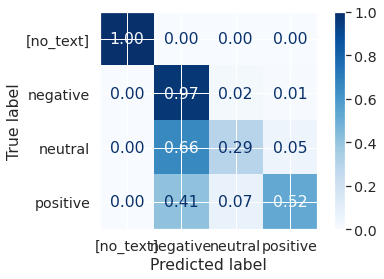

In [ ]:
grid_search(tdidf,mnb,vect_parameters,mnb_parameters)

## LogisticRegression

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__max_iter': (100, 500, 1000),
 'vect__max_df': (0.25, 0.5, 0.75),
 'vect__min_df': (1, 2),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 14.1min finished


done in 849.676s
Best CV score: 0.786
Best parameters set:
	clf__C: 1.0
	clf__max_iter: 100
	vect__max_df: 0.25
	vect__min_df: 1
	vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.795


Classification Report Test Data
              precision    recall  f1-score   support

   [no_text]       1.00      1.00      1.00         1
    negative       0.80      0.94      0.87       910
     neutral       0.73      0.48      0.58       320
    positive       0.83      0.67      0.74       233

    accuracy                           0.80      1464
   macro avg       0.84      0.77      0.80      1464
weighted avg       0.79      0.80      0.78      1464

Confusion matrix
[[  1   0   0   0]
 [  0 855  40  15]
 [  0 150 153  17]
 [  0  61  17 155]]



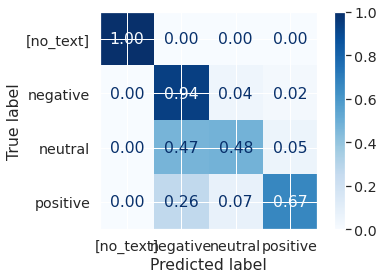

In [ ]:
grid_search(tdidf,logreg,vect_parameters,logreg_parameters)

# Word2Vect

We will also use the Word2Vect method for embedding words. Word2Vect produces dense vectors instead of sparse vectors, which give, at the end, generally better results.

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA #Grab PCA functions
sentences=[]
for txt in X_train:
  row = txt.split(' ')
  sentences.append(row)

model = Word2Vec(sentences,min_count=5)
words = list(model.wv.vocab)

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

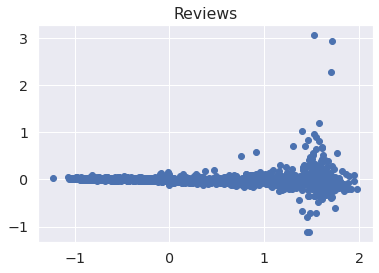

In [ ]:
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Reviews')
plt.show()

In [ ]:
def tsne_plot(model):
  labels = []
  tokens = []  
  for word in model.wv.vocab:
    tokens.append(model[word])  
    labels.append(word)  

  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)  
  new_values = tsne_model.fit_transform(tokens)  

  x = []  
  y = []  
  for value in new_values:  
    x.append(value[0])  
    y.append(value[1])  
  plt.figure(figsize=(8, 8))
  for i in range(len(x)):
    if labels[i] in ['plane','gate','tarmac','sit']:
      plt.scatter(x[i],y[i])
      plt.annotate(labels[i], xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.show()  
  

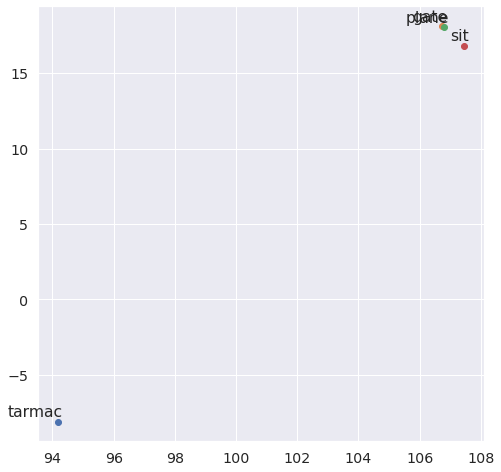

In [ ]:
tsne_plot(model)  


In [ ]:
model = gensim.models.Word2Vec(sentences
                 , min_count=1
                 , size=25
                 , window=4
                 , workers=4)

In [ ]:
model.most_similar('plane', topn=3)

[('gate', 0.9992666244506836),
 ('tarmac', 0.9984604120254517),
 ('sit', 0.9979232549667358)]

In [ ]:
model.wv.vocab

{'synonym': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec240>,
 'rude': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec208>,
 'cheap': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec198>,
 'realli': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec160>,
 'know': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec128>,
 'valu': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec0f0>,
 'custom': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec0b8>,
 'flight': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec080>,
 'jacksonvil': <gensim.models.keyedvectors.Vocab at 0x7f3e3eaec048>,
 'fl': <gensim.models.keyedvectors.Vocab at 0x7f3e3ec22908>,
 'dalla': <gensim.models.keyedvectors.Vocab at 0x7f3e4ab49d30>,
 'show': <gensim.models.keyedvectors.Vocab at 0x7f3e4ab49d68>,
 'cancel': <gensim.models.keyedvectors.Vocab at 0x7f3e4ab49da0>,
 'flightl': <gensim.models.keyedvectors.Vocab at 0x7f3e4ab49dd8>,
 'go': <gensim.models.keyedvectors.Vocab at 0x7f3e4ab49e10>,
 'rebook': <gensim.models.keyedvector

# Conclusion

* overall LogisticRegression gives better results than multinomial Naïves Bayes
* the best results are obtained with both ```CountVectorizer``` and ```LogisticRegression```